## G-7. Ensemble simulation using different decisions and parameter trials setting

## 1. Import pySUMMA 3.0.0

In [1]:
import pysumma as ps
import numpy as np
import xarray as xr

## 2. Create Simulatioin Object

In [2]:
executable = "/usr/bin/summa.exe"
file_manager = 'SummaModel_ReynoldsAspenStand_StomatalResistance/settings/summa_fileManager_riparianAspenSimpleResistance.txt'

s = ps.Simulation(executable, file_manager)

## 3. Ensemble Simulations using different decisions and parameter trials setting

In [3]:
decision_options = {"stomResist": ["BallBerry", "Jarvis", "simpleResistance"]}
param_trial_options = {'rootDistExp': np.array([1.0, 0.5, 0.25])}
total_config = ps.ensemble.total_product(dec_conf=decision_options, param_trial_conf=param_trial_options)
total_ens = ps.Ensemble(executable, total_config, file_manager, num_workers=4)

/opt/conda/envs/pysumma/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36615 instead
  warnings.warn(


In [4]:
total_ens.run('local')

In [5]:
# check the status of ensemble simualtion
total_ens.summary()

{'success': ['++BallBerry++rootDistExp=1.0++',
  '++BallBerry++rootDistExp=0.5++',
  '++BallBerry++rootDistExp=0.25++',
  '++Jarvis++rootDistExp=1.0++',
  '++Jarvis++rootDistExp=0.5++',
  '++Jarvis++rootDistExp=0.25++',
  '++simpleResistance++rootDistExp=1.0++',
  '++simpleResistance++rootDistExp=0.5++',
  '++simpleResistance++rootDistExp=0.25++'],
 'error': [],
 'other': []}

In [ ]:
# if there are errors in ensemble simulations, you can execute SUMMA again
total_ens.rerun_failed('local')

In [6]:
out_file_paths = [s.get_output_files() for s in total_ens.simulations.values()]
out_file_paths

[['/home/jovyan/work/SUMMA3_Manual/SummaModel_ReynoldsAspenStand_StomatalResistance/output/vegImpactsTranspire_++BallBerry++rootDistExp=1.0++_timestep.nc'],
 ['/home/jovyan/work/SUMMA3_Manual/SummaModel_ReynoldsAspenStand_StomatalResistance/output/vegImpactsTranspire_++BallBerry++rootDistExp=0.5++_timestep.nc'],
 ['/home/jovyan/work/SUMMA3_Manual/SummaModel_ReynoldsAspenStand_StomatalResistance/output/vegImpactsTranspire_++BallBerry++rootDistExp=0.25++_timestep.nc'],
 ['/home/jovyan/work/SUMMA3_Manual/SummaModel_ReynoldsAspenStand_StomatalResistance/output/vegImpactsTranspire_++Jarvis++rootDistExp=1.0++_timestep.nc'],
 ['/home/jovyan/work/SUMMA3_Manual/SummaModel_ReynoldsAspenStand_StomatalResistance/output/vegImpactsTranspire_++Jarvis++rootDistExp=0.5++_timestep.nc'],
 ['/home/jovyan/work/SUMMA3_Manual/SummaModel_ReynoldsAspenStand_StomatalResistance/output/vegImpactsTranspire_++Jarvis++rootDistExp=0.25++_timestep.nc'],
 ['/home/jovyan/work/SUMMA3_Manual/SummaModel_ReynoldsAspenStand_

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

# Create Method to Calculate Total ET for Each Hour of Day from SUMMA Output
def calc_total_et(et_output_df):
    total_et_data = (et_output_df['scalarLatHeatTotal'])*3600/2260000
    # create dates(X-axis) attribute from ouput netcdf
    dates = total_et_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = total_et_data.data
    # create two dimensional tabular data structure 
    total_et_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_et_df.index = total_et_df.index.round("H")
    # set the time period to display plot 
    total_et_df = total_et_df.loc["2007-05-31 23:00:00":"2007-08-20 23:00:00"]
    # resample data by the average value hourly
    total_et_df_hourly = total_et_df.resample("H").mean()
    # resample data by the average for hour of day
    total_et_by_hour = total_et_df_hourly.groupby(total_et_df_hourly.index.hour).mean()
    total_et_by_hour.index.name = 'hour'
    total_et_by_hour.columns = ['ET']
    # calculate 3 hour moving average
    total_et_by_hour.loc['24'] = total_et_by_hour.loc[0].values
    for index in range(1,23,1):
        total_et_by_hour['ET'][index] = (total_et_by_hour['ET'][index-1]+total_et_by_hour['ET'][index]+total_et_by_hour['ET'][index+1])/3
    return total_et_by_hour

# Add Obervation Data from Aspen station in Reynolds Mountain East
file_manager.split('/settings')[0]+'/testCases_data/validationData/ReynoldsCreek_eddyFlux.nc'
# create pySUMMA Plotting Object
Val_eddyFlux = xr.open_dataset(file_manager.split('/settings')[0]+'/data/validationData/ReynoldsCreek_eddyFlux.nc')
# read Total Evapotranspiration(LE-wpl) AND Wind(WindFlag) from validation netcdf file
Obs_Evapotranspitaton = Val_eddyFlux['LE-wpl']
Obs_Wind = Val_eddyFlux['WindFlag']
# create dates(X-axis) attribute from validation netcdf file
dates = Obs_Evapotranspitaton.coords['time'].data
# create obs_data(Y-axis) attribute from validation netcdf file
obs_evap = Obs_Evapotranspitaton.data
obs_wind = Obs_Wind.data
# create two dimensional tabular data structure 
df_evap = pd.DataFrame(obs_evap, index=dates)
df_wind = pd.DataFrame(obs_wind, index=dates)
# set the time period to display plot
df_evap_filt = df_evap.loc["2007-05-31 23:00:00":"2007-08-20 22:30:00"]
df_wind_filt = df_wind.loc["2007-05-31 23:00:00":"2007-08-20 22:30:00"]   #"2007-06-01":"2007-08-20"
# select aspen obervation station among three different stations
df_evap_filt.columns = ['-','Obs_evap (aspen)','-']
df_wind_filt.columns = ['-','Obs_wind (aspen)','-']
# Combine total evapotranspiration and wind data
obs_output = pd.concat([df_evap_filt['Obs_evap (aspen)'], df_wind_filt['Obs_wind (aspen)']], axis=1)
# add hour column
obs_output['hour'] = obs_output.index.hour
# drop NaN and select row of wind = 0
obs_output1 = obs_output.dropna()
hourly_obs = obs_output1.loc[obs_output1['Obs_wind (aspen)'] == 0]
# select obs data that has both 30min and 1hour data
df = pd.DataFrame(hourly_obs['hour'].values, index=hourly_obs.index, columns=["hour1"])
count = 0
for index, value in df.iterrows():
    if df.loc[:, ['hour1']].iloc[count].values == df.loc[:, ['hour1']].iloc[count+1].values:
        if count >= len(df)-3:
            break
        count = count + 2
        pass
    else:
        df.iloc[count] = 100
        count = count + 1        
        
# select and delete row of wind = 100
delete_row = hourly_obs[hourly_obs.iloc[:,2]==100].index
hourly_obs = hourly_obs.drop(delete_row)
evap_hourly = hourly_obs.loc[:, ['Obs_evap (aspen)']]
evap_hourly["Observations"] = evap_hourly['Obs_evap (aspen)'].values
# select evapotranspiration data at aspen station
evap_hourly = hourly_obs.loc[:, ['Obs_evap (aspen)']]
evap_hourly["Observations"] = evap_hourly['Obs_evap (aspen)'].values
# resample data by the average for hour of day
df_gp_hr = evap_hourly.groupby([evap_hourly.index.hour, evap_hourly.index.minute]).mean()
# Change unit from kgm-2s-1 to mm/hr 
df_gp_hr = df_gp_hr/2260000*3600
# reset index so each row has an hour an minute column
df_gp_hr.reset_index(inplace=True)
# add hour and minute columns for plotting
xvals = df_gp_hr.reset_index()['level_0'] + df_gp_hr.reset_index()['level_1']/60.

In [8]:
# 1 Plot
BallBerry_rootDisExp_1_0 = xr.open_dataset(out_file_paths[0][0])
BallBerry_rootDisExp_0_5 = xr.open_dataset(out_file_paths[1][0])
BallBerry_rootDisExp_0_25 = xr.open_dataset(out_file_paths[2][0])
BallBerry_rootDisExp_1_0_hour = calc_total_et(BallBerry_rootDisExp_1_0)
BallBerry_rootDisExp_0_5_hour = calc_total_et(BallBerry_rootDisExp_0_5)
BallBerry_rootDisExp_0_25_hour = calc_total_et(BallBerry_rootDisExp_0_25)
# 2 Plot
Jarvis_rootDisExp_1_0 = xr.open_dataset(out_file_paths[3][0])
Jarvis_rootDisExp_0_5 = xr.open_dataset(out_file_paths[4][0])
Jarvis_rootDisExp_0_25 = xr.open_dataset(out_file_paths[5][0])
Jarvis_rootDisExp_1_0_hour = calc_total_et(Jarvis_rootDisExp_1_0)
Jarvis_rootDisExp_0_5_hour = calc_total_et(Jarvis_rootDisExp_0_5)
Jarvis_rootDisExp_0_25_hour = calc_total_et(Jarvis_rootDisExp_0_25)

# 3 Plot
simpleResistance_rootDisExp_1_0 = xr.open_dataset(out_file_paths[6][0])
simpleResistance_rootDisExp_0_5 = xr.open_dataset(out_file_paths[7][0])
simpleResistance_rootDisExp_0_25 = xr.open_dataset(out_file_paths[8][0])
simpleResistance_rootDisExp_1_0_hour = calc_total_et(simpleResistance_rootDisExp_1_0)
simpleResistance_rootDisExp_0_5_hour = calc_total_et(simpleResistance_rootDisExp_0_5)
simpleResistance_rootDisExp_0_25_hour = calc_total_et(simpleResistance_rootDisExp_0_25)

# 4 Plot
rootDisExp_1_0_BallBerry = xr.open_dataset(out_file_paths[0][0])
rootDisExp_1_0_Jarvis = xr.open_dataset(out_file_paths[3][0])
rootDisExp_1_0_simpleResistance = xr.open_dataset(out_file_paths[6][0])
rootDisExp_1_0_BallBerry_hour = calc_total_et(rootDisExp_1_0_BallBerry)
rootDisExp_1_0_Jarvis_hour = calc_total_et(rootDisExp_1_0_Jarvis)
rootDisExp_1_0_simpleResistance_hour = calc_total_et(rootDisExp_1_0_simpleResistance)

# 5 Plot
rootDisExp_0_5_BallBerry = xr.open_dataset(out_file_paths[1][0])
rootDisExp_0_5_Jarvis = xr.open_dataset(out_file_paths[4][0])
rootDisExp_0_5_simpleResistance = xr.open_dataset(out_file_paths[7][0])
rootDisExp_0_5_BallBerry_hour = calc_total_et(rootDisExp_0_5_BallBerry)
rootDisExp_0_5_Jarvis_hour = calc_total_et(rootDisExp_0_5_Jarvis)
rootDisExp_0_5_simpleResistance_hour = calc_total_et(rootDisExp_0_5_simpleResistance)

# 6 Plot
rootDisExp_0_25_BallBerry = xr.open_dataset(out_file_paths[2][0])
rootDisExp_0_25_Jarvis = xr.open_dataset(out_file_paths[5][0])
rootDisExp_0_25_simpleResistance = xr.open_dataset(out_file_paths[8][0])
rootDisExp_0_25_BallBerry_hour = calc_total_et(rootDisExp_0_25_BallBerry)
rootDisExp_0_25_Jarvis_hour = calc_total_et(rootDisExp_0_25_Jarvis)
rootDisExp_0_25_simpleResistance_hour = calc_total_et(rootDisExp_0_25_simpleResistance)

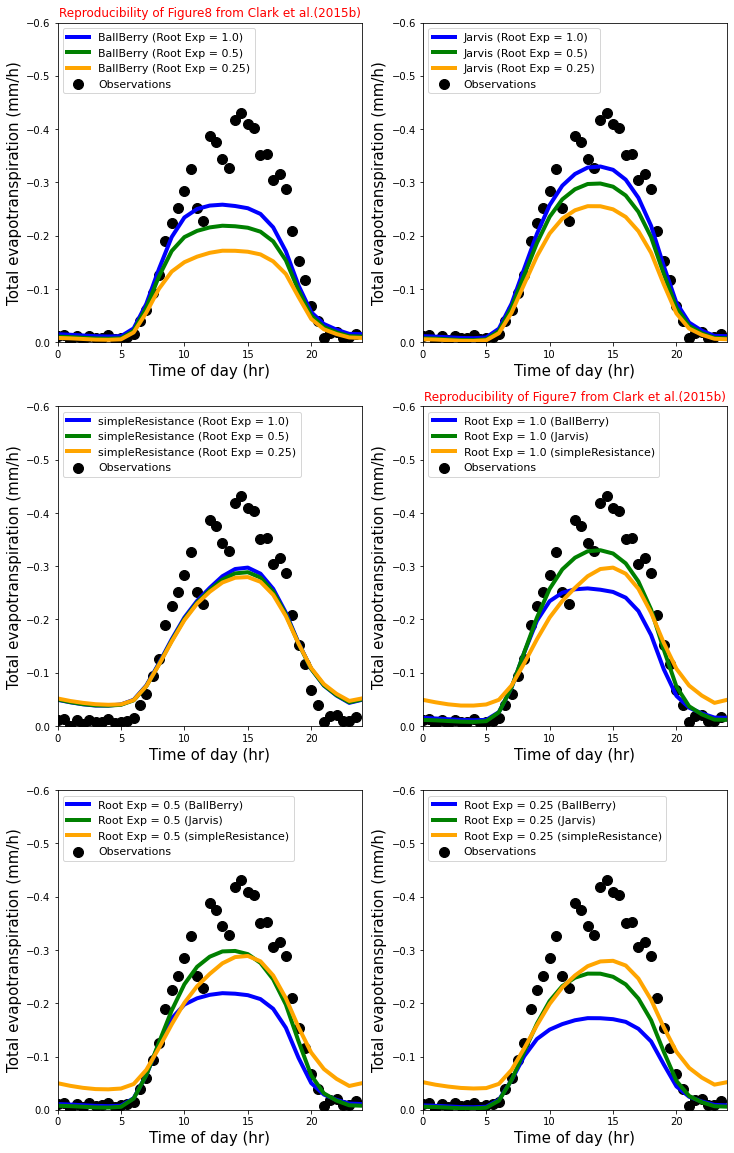

In [9]:
fig = plt.figure(figsize=(12,20))
ax1 = fig.add_subplot(321)
ax1.set_title("Reproducibility of Figure8 from Clark et al.(2015b)", fontsize=12, color='red')
ax1.plot(BallBerry_rootDisExp_1_0_hour.index, BallBerry_rootDisExp_1_0_hour['ET'], label='BallBerry (Root Exp = 1.0)', color='blue', linewidth=4.0)
ax1.plot(BallBerry_rootDisExp_0_5_hour.index, BallBerry_rootDisExp_0_5_hour['ET'], label='BallBerry (Root Exp = 0.5)', color='green', linewidth=4.0)
ax1.plot(BallBerry_rootDisExp_0_25_hour.index, BallBerry_rootDisExp_0_25_hour['ET'], label='BallBerry (Root Exp = 0.25)', color='orange', linewidth=4.0)

ax2 = fig.add_subplot(322)
ax2.plot(Jarvis_rootDisExp_1_0_hour.index, Jarvis_rootDisExp_1_0_hour['ET'], label='Jarvis (Root Exp = 1.0)', color='blue', linewidth=4.0)
ax2.plot(Jarvis_rootDisExp_0_5_hour.index, Jarvis_rootDisExp_0_5_hour['ET'], label='Jarvis (Root Exp = 0.5)', color='green', linewidth=4.0)
ax2.plot(Jarvis_rootDisExp_0_25_hour.index, Jarvis_rootDisExp_0_25_hour['ET'], label='Jarvis (Root Exp = 0.25)', color='orange', linewidth=4.0)

ax3 = fig.add_subplot(323)
ax3.plot(simpleResistance_rootDisExp_1_0_hour.index, simpleResistance_rootDisExp_1_0_hour['ET'], label='simpleResistance (Root Exp = 1.0)', color='blue', linewidth=4.0)
ax3.plot(simpleResistance_rootDisExp_0_5_hour.index, simpleResistance_rootDisExp_0_5_hour['ET'], label='simpleResistance (Root Exp = 0.5)', color='green', linewidth=4.0)
ax3.plot(simpleResistance_rootDisExp_0_25_hour.index, simpleResistance_rootDisExp_0_25_hour['ET'], label='simpleResistance (Root Exp = 0.25)', color='orange', linewidth=4.0)

ax4 = fig.add_subplot(324)
ax4.set_title("Reproducibility of Figure7 from Clark et al.(2015b)", fontsize=12, color='red')
ax4.plot(rootDisExp_1_0_BallBerry_hour.index, rootDisExp_1_0_BallBerry_hour['ET'], label='Root Exp = 1.0 (BallBerry)', color='blue', linewidth=4.0)
ax4.plot(rootDisExp_1_0_Jarvis_hour.index, rootDisExp_1_0_Jarvis_hour['ET'], label='Root Exp = 1.0 (Jarvis)', color='green', linewidth=4.0)
ax4.plot(rootDisExp_1_0_simpleResistance_hour.index, rootDisExp_1_0_simpleResistance_hour['ET'], label='Root Exp = 1.0 (simpleResistance)', color='orange', linewidth=4.0)

ax5 = fig.add_subplot(325)
ax5.plot(rootDisExp_0_5_BallBerry_hour.index, rootDisExp_0_5_BallBerry_hour['ET'], label='Root Exp = 0.5 (BallBerry)', color='blue', linewidth=4.0)
ax5.plot(rootDisExp_0_5_Jarvis_hour.index, rootDisExp_0_5_Jarvis_hour['ET'], label='Root Exp = 0.5 (Jarvis)', color='green', linewidth=4.0)
ax5.plot(rootDisExp_0_5_simpleResistance_hour.index, rootDisExp_0_5_simpleResistance_hour['ET'], label='Root Exp = 0.5 (simpleResistance)', color='orange', linewidth=4.0)

ax6 = fig.add_subplot(326)
ax6.plot(rootDisExp_0_25_BallBerry_hour.index, rootDisExp_0_25_BallBerry_hour['ET'], label='Root Exp = 0.25 (BallBerry)', color='blue', linewidth=4.0)
ax6.plot(rootDisExp_0_25_Jarvis_hour.index, rootDisExp_0_25_Jarvis_hour['ET'], label='Root Exp = 0.25 (Jarvis)', color='green', linewidth=4.0)
ax6.plot(rootDisExp_0_25_simpleResistance_hour.index, rootDisExp_0_25_simpleResistance_hour['ET'], label='Root Exp = 0.25 (simpleResistance)', color='orange', linewidth=4.0)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
for ax in axes:
    # invert y axis
    ax.invert_yaxis()
    # plot scatter with x='xvals', y='Observation (aspen)'
    ax.scatter(xvals, df_gp_hr['Observations'], color='black', s=100, label="Observations")
    # add x, y label
    ax.set_xlabel('Time of day (hr)', fontsize=15)
    ax.set_ylabel('Total evapotranspiration (mm/h)', fontsize=15)
    # show up the legend
    ax.legend(fontsize=11, loc=2)
    ax.set_xlim([0,24])
    ax.set_ylim([0,-0.6])